In [ ]:
!pip install torch torchvision

In [ ]:
!kaggle datasets download -d phunghieu/global-wheat-detection-768x768


Dataset URL: https://www.kaggle.com/datasets/phunghieu/global-wheat-detection-768x768
License(s): unknown
100% 856M/858M [00:33<00:00, 25.6MB/s]
100% 858M/858M [00:33<00:00, 26.9MB/s]


In [ ]:
!unzip global-wheat-detection-768x768.zip -d wheat_dataset



Archive:  global-wheat-detection-768x768.zip
  inflating: wheat_dataset/sample_submission.csv  
  inflating: wheat_dataset/test/2fd875eaa.jpg  
  inflating: wheat_dataset/test/348a992bb.jpg  
  inflating: wheat_dataset/test/51b3e36ab.jpg  
  inflating: wheat_dataset/test/51f1be19e.jpg  
  inflating: wheat_dataset/test/53f253011.jpg  
  inflating: wheat_dataset/test/796707dd7.jpg  
  inflating: wheat_dataset/test/aac893a91.jpg  
  inflating: wheat_dataset/test/cb8d261a3.jpg  
  inflating: wheat_dataset/test/cc3532ff6.jpg  
  inflating: wheat_dataset/test/f5a1f0358.jpg  
  inflating: wheat_dataset/train.csv  
  inflating: wheat_dataset/train/00333207f.jpg  
  inflating: wheat_dataset/train/005b0d8bb.jpg  
  inflating: wheat_dataset/train/006a994f7.jpg  
  inflating: wheat_dataset/train/00764ad5d.jpg  
  inflating: wheat_dataset/train/00b5fefed.jpg  
  inflating: wheat_dataset/train/00b70a919.jpg  
  inflating: wheat_dataset/train/00e903abe.jpg  
  inflating: wheat_dataset/train/00ea5e5ee

In [ ]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms as T
from sklearn.model_selection import train_test_split
from PIL import Image,ImageDraw
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [ ]:
train=pd.read_csv('wheat_dataset/train.csv')
train.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,768,768,"[625.5, 166.5, 42.0, 27.0]",usask_1
1,b6ab77fd7,768,768,"[169.5, 411.0, 97.5, 43.5]",usask_1
2,b6ab77fd7,768,768,"[282.75, 378.0, 55.5, 120.0]",usask_1
3,b6ab77fd7,768,768,"[625.5, 71.25, 81.75, 80.25]",usask_1
4,b6ab77fd7,768,768,"[19.5, 108.0, 93.0, 87.75]",usask_1


In [ ]:


# Assuming 'train' is your DataFrame and 'bbox' contains bounding box values as strings like "[x1,y1,w,h]"
coord = pd.DataFrame(train.bbox.apply(lambda x: x[1:-1].split(',')).tolist(), columns=['x1', 'y1', 'w', 'h'])


In [ ]:
df=pd.concat([train,coord],axis=1)
df.drop('bbox',axis=1,inplace=True)
df.head()

,image_id,width,height,source,x1,y1,w,h
0,b6ab77fd7,768,768,usask_1,625.5,166.5,42.0,27.0
1,b6ab77fd7,768,768,usask_1,169.5,411.0,97.5,43.5
2,b6ab77fd7,768,768,usask_1,282.75,378.0,55.5,120.0
3,b6ab77fd7,768,768,usask_1,625.5,71.25,81.75,80.25
4,b6ab77fd7,768,768,usask_1,19.5,108.0,93.0,87.75


In [ ]:
df['x1'] = pd.to_numeric(df['x1'])
df['y1'] = pd.to_numeric(df['y1'])
df['w'] = pd.to_numeric(df['w'])
df['h'] = pd.to_numeric(df['h'])


In [ ]:
df['x2']=df['x1']+df['w']
df['y2']=df['y1']+df['h']
df.head()

,image_id,width,height,source,x1,y1,w,h,x2,y2
0,b6ab77fd7,768,768,usask_1,625.50,166.50,42.00,27.00,667.50,193.50
1,b6ab77fd7,768,768,usask_1,169.50,411.00,97.50,43.50,267.00,454.50
2,b6ab77fd7,768,768,usask_1,282.75,378.00,55.50,120.00,338.25,498.00
3,b6ab77fd7,768,768,usask_1,625.50,71.25,81.75,80.25,707.25,151.50
4,b6ab77fd7,768,768,usask_1,19.50,108.00,93.00,87.75,112.50,195.75


In [ ]:
# Drop columns 'source', 'width', 'height', 'w', 'h'
df.drop(['source', 'width', 'height', 'w', 'h'], axis=1, inplace=True)

# Display the first few rows of the DataFrame
df.head()


,image_id,x1,y1,x2,y2
0,b6ab77fd7,625.50,166.50,667.50,193.50
1,b6ab77fd7,169.50,411.00,267.00,454.50
2,b6ab77fd7,282.75,378.00,338.25,498.00
3,b6ab77fd7,625.50,71.25,707.25,151.50
4,b6ab77fd7,19.50,108.00,112.50,195.75


In [ ]:
unique_imgs=df.image_id.unique()
unique_imgs

array(['b6ab77fd7', 'b53afdf5c', '7b72ea0fb', ..., 'a5c8d5f5c',
       'e6b5e296d', '5e0747034'], dtype=object)

In [ ]:
class custDat(torch.utils.data.Dataset):
    def __init__(self, df, unique_imgs, indices):
        self.df = df
        self.unique_imgs = unique_imgs
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # Get the image name from the unique image IDs
        image_name = self.unique_imgs[self.indices[idx]]

        # Get bounding box coordinates and convert to a numpy array
        boxes = self.df[self.df.image_id == image_name][['x1', 'y1', 'x2', 'y2']].values.astype('float')

        # Create a label tensor. Assuming binary classification, the label is 1 for all boxes
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)

        # Open the image and convert to RGB
        img = Image.open('wheat_dataset/train/' + image_name + ".jpg").convert('RGB')

        # Create the target dictionary
        target = {}
        target['boxes'] = torch.tensor(boxes)
        target['labels'] = labels  # Assign labels correctly

        # Return the image and target dictionary
        return T.ToTensor()(img), target

In [ ]:
train_inds,val_inds=train_test_split(range(unique_imgs.shape[0]),test_size=0.1)

In [ ]:
def custom_collate(data):
  return data

In [ ]:
train_dl=torch.utils.data.DataLoader(custDat(df,unique_imgs,train_inds),batch_size=16,shuffle=True,collate_fn=custom_collate,pin_memory=True if torch.cuda.is_available() else False)
val_dl=torch.utils.data.DataLoader(custDat(df,unique_imgs,val_inds),batch_size=16,shuffle=True,collate_fn=custom_collate,pin_memory=True if torch.cuda.is_available() else False)

In [ ]:
model=torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 162MB/s]


In [ ]:
num_classes=2
in_features=model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor=FastRCNNPredictor(in_features,num_classes)

In [ ]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
num_epochs=5

In [ ]:
model.to(device)
for epoch in range(num_epochs):
  epoch_loss=0
  for data in train_dl:
    imgs=[]
    targets=[]
    for d in data:
      imgs.append(d[0].to(device))
      targ={}
      targ['boxes']=d[1]['boxes'].to(device)
      targ['labels']=d[1]['labels'].to(device)

      targets.append(targ)
    loss_dict=model(imgs,targets)
    losses=sum(loss for loss in loss_dict.values())
    epoch_loss+=losses.cpu().detach().numpy()
    optimizer.zero_grad()
    losses.backward()
    optimizer.step()
  print(epoch_loss)

352.38890151816196
210.25974831167966
173.68337112569515
160.0142125189468
152.94339715317312


In [ ]:
model.eval()
data=next(iter(val_dl))

In [ ]:
img=data[0][0]
boxes=data[0][1]['boxes']
labels=data[0][1]['labels']

In [ ]:
output=model([img.to(device)])
output

[{'boxes': tensor([[324.7658, 639.6832, 398.2935, 717.9058],
          [150.6392, 498.5324, 235.4694, 573.8728],
          [268.3146,  55.4025, 377.4256, 238.9424],
          [159.6907, 693.2609, 250.5686, 752.6619],
          [122.1182, 116.2863, 250.4580, 240.8098],
          [237.1983, 327.1252, 303.7016, 387.2556],
          [588.1038, 551.4555, 678.0508, 700.9208],
          [660.9586, 267.1907, 747.7699, 336.8192],
          [252.1510, 472.7900, 327.8542, 628.9767],
          [228.4505, 143.3131, 294.6523, 205.2351],
          [648.4453, 144.3521, 766.3198, 249.6167],
          [681.5242, 674.7738, 743.0991, 730.5361],
          [ 49.9609,  45.7292, 101.6482,  99.7389],
          [633.1271, 704.8099, 712.0598, 766.5147],
          [ 93.3530, 495.9756, 160.4597, 676.3707],
          [ 64.2322,  78.5422, 135.6193, 272.8884],
          [243.4853, 382.8391, 463.6145, 474.4990],
          [730.6636, 252.0445, 768.0000, 321.4975],
          [234.2592, 440.6331, 341.1141, 487.6120],
   

In [ ]:
out_bbox=output[0]['boxes']
out_scores=output[0]['scores']

In [ ]:
keep=torchvision.ops.nms(out_bbox,out_scores,0.5)

In [ ]:
out_bbox.shape , keep.shape

(torch.Size([67, 4]), torch.Size([67]))

array([[[ 16,  14,   0],
        [ 17,  15,   0],
        [ 19,  17,   4],
        ...,
        [ 56,  68,  48],
        [ 58,  70,  50],
        [ 64,  76,  56]],

       [[ 16,  14,   0],
        [ 18,  16,   1],
        [ 21,  19,   6],
        ...,
        [ 56,  68,  48],
        [ 58,  70,  50],
        [ 62,  74,  54]],

       [[ 14,  12,   0],
        [ 18,  16,   1],
        [ 20,  21,   7],
        ...,
        [ 58,  70,  48],
        [ 61,  75,  52],
        [ 64,  78,  55]],

       ...,

       [[ 32,  35,  18],
        [ 31,  34,  17],
        [ 30,  33,  16],
        ...,
        [141, 156, 137],
        [146, 161, 142],
        [148, 163, 144]],

       [[ 33,  34,  16],
        [ 33,  34,  16],
        [ 33,  36,  19],
        ...,
        [139, 156, 137],
        [144, 159, 140],
        [147, 162, 143]],

       [[ 30,  31,  13],
        [ 32,  33,  15],
        [ 32,  35,  18],
        ...,
        [142, 159, 140],
        [141, 156, 137],
        [144, 159, 140]]], dtype=uint8)
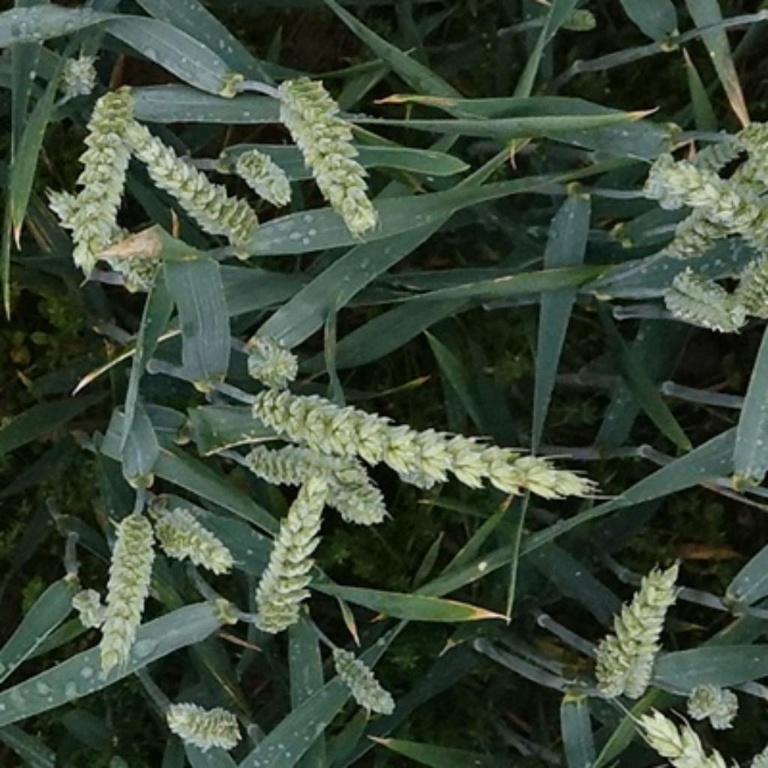

In [ ]:
im=(img.permute(1,2,0).cpu().detach().numpy()*255).astype('uint8')
im

In [ ]:
vsample=Image.fromarray(im)
draw=ImageDraw.Draw(vsample)
for box in out_bbox[keep].cpu().detach().numpy():
  draw.rectangle([(box[0],box[1]),(box[2],box[3])],outline='red')

In [ ]:
torch.save(model.state_dict(),'model.pth')


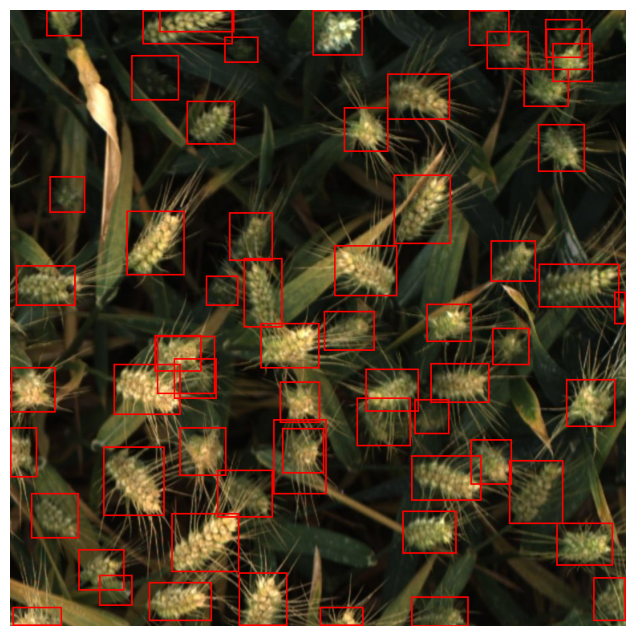

In [ ]:

# Set model to evaluation mode
model.eval()

# Get a batch of validation data
data = next(iter(val_dl))
img, target = data[0]  # Unpack the image and target

# Move image to GPU if available
img = img.to(device)

# Get model predictions
output = model([img])
out_bbox = output[0]['boxes']
out_scores = output[0]['scores']

# Apply Non-Maximum Suppression (NMS)
keep = torchvision.ops.nms(out_bbox, out_scores, 0.5)

# Convert Image Tensor to NumPy for Visualization
im = (img.permute(1, 2, 0).cpu().detach().numpy() * 255).astype('uint8')

# Convert to PIL Image
vsample = Image.fromarray(im)
draw = ImageDraw.Draw(vsample)

# Draw Predicted Bounding Boxes (Red)
for box in out_bbox[keep].cpu().detach().numpy():
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red', width=2)

# Display Image Using Matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(vsample)
plt.axis("off")  # Hide axis
plt.show()


In [ ]:
def create_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Load Saved Model
model2 = create_model(num_classes)
model2.load_state_dict(torch.load('model.pth'))
model2.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 176MB/s]
<ipython-input-39-f48416f2ebb2>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

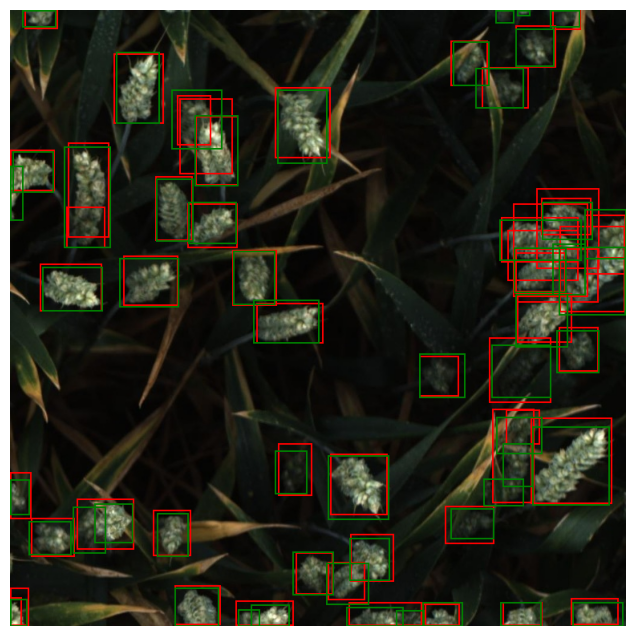

In [ ]:
model2.eval()
data = next(iter(val_dl))  # Get a batch of validation data
img = data[0][0]  # Get the image tensor
boxes = data[0][1]['boxes']  # Get ground truth bounding boxes
labels = data[0][1]['labels']  # Get labels

# Move image to device and get model prediction
output = model2([img.to(device)])
out_bbox = output[0]['boxes'].cpu().detach().numpy()  # Convert to numpy
out_scores = output[0]['scores'].cpu().detach().numpy()  # Convert to numpy

# Apply Non-Maximum Suppression (NMS)
keep = torchvision.ops.nms(torch.tensor(out_bbox), torch.tensor(out_scores), 0.5)
filtered_boxes = out_bbox[keep.numpy()]  # Only keep selected boxes

# Convert image to NumPy format
im = (img.permute(1,2,0).cpu().detach().numpy() * 255).astype('uint8')

# Create an Image object for drawing
vsample = Image.fromarray(im)
draw = ImageDraw.Draw(vsample)

# Draw predicted bounding boxes in **red**
for box in filtered_boxes:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline="red", width=2)

# Draw ground truth bounding boxes in **green**
for box in boxes.cpu().detach().numpy():
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline="green", width=2)

# Show the image using Matplotlib instead of Image.show()
plt.figure(figsize=(8, 8))
plt.imshow(vsample)
plt.axis("off")  # Hide axes
plt.show()